In [1]:
# Installs
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

In [4]:
# Load the Dataset
df = pd.read_csv("Data/synthetic_exam_data2.csv")
df.head()

,reference_id,SATS,GCSE,GCE_AS,GCE_A
0,835724108,107,5,B,B
1,489964504,97,4,D,B
2,153659217,111,6,A,A*
3,301853339,113,8,A,A
4,968991804,90,3,D,D


In [5]:
# Add controlled noise to GCSE and SATS
np.random.seed(42)
df["GCSE_noisy"] = df["GCSE"] + np.random.normal(0, 2, size=len(df))
df["SATS_noisy"] = df["SATS"] + np.random.normal(0, 1.5, size=len(df))

# Clip to valid score ranges
df["GCSE_noisy"] = df["GCSE_noisy"].clip(0, 100)
df["SATS_noisy"] = df["SATS_noisy"].clip(0, 120)


In [6]:
# Mapping for A-level grades
a_level_points = {
    "A*": 60,
    "A": 50,
    "B": 40,
    "C": 30,
    "D": 20,
    "E": 10,
    "U": 0
}

df["GCE_A_Value"] = df["GCE_A"].map(a_level_points)

In [7]:
# Introduce 5% exceptions
np.random.seed(42)
n_exceptions = int(0.05 * len(df))
exception_idx = np.random.choice(df.index, n_exceptions, replace=False)

# Flip A_Grade for these students
df["A_Grade"] = df["GCE_A"].isin(["A", "A*"]).astype(int)

np.random.seed(42)
n_exceptions = int(0.05 * len(df))
exception_idx = np.random.choice(df.index, n_exceptions, replace=False)
df.loc[exception_idx, "A_Grade"] = 1 - df.loc[exception_idx, "A_Grade"]


In [8]:
# Mapping for AS-level grades
as_level_points = {
    "A": 25,
    "B": 20,
    "C": 15,
    "D": 10,
    "E": 5,
    "U": 0
}

df["GCE_AS_Value"] = df["GCE_AS"].map(as_level_points)

In [9]:
# Standardize the Data (for clustering)
initial_scaler = StandardScaler()
df[["GCE_A_ValueStan", "GCE_AS_ValueStan", "GCSEStan", "SATStan"]] = \
    initial_scaler.fit_transform(df[["GCE_A_Value", "GCE_AS_Value", "GCSE", "SATS"]])

df.head()

,reference_id,SATS,GCSE,GCE_AS,GCE_A,GCSE_noisy,SATS_noisy,GCE_A_Value,A_Grade,GCE_AS_Value,GCE_A_ValueStan,GCE_AS_ValueStan,GCSEStan,SATStan
0,835724108,107,5,B,B,5.993428,109.342761,40,0,20,0.097111,0.123804,-0.411730,0.264800
1,489964504,97,4,D,B,3.723471,96.858658,40,0,10,0.097111,-1.960878,-1.004573,-1.053444
2,153659217,111,6,A,A*,7.295377,109.005697,60,1,25,1.894798,1.166145,0.181114,0.792098
3,301853339,113,8,A,A,11.046060,110.917043,50,1,25,0.995954,1.166145,1.366800,1.055747
4,968991804,90,3,D,D,2.531693,89.486024,20,1,10,-1.700576,-1.960878,-1.597416,-1.976215


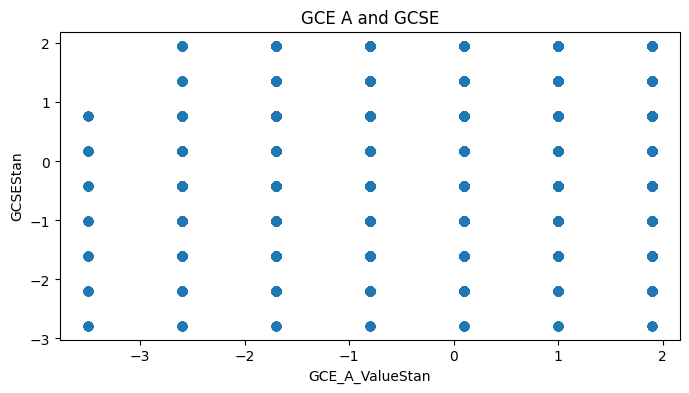

In [10]:
# Visualise A levels and GCSE
plt.figure(figsize=(8,4))
plt.scatter(df["GCE_A_ValueStan"], df["GCSEStan"])
plt.title("GCE A and GCSE")
plt.xlabel("GCE_A_ValueStan")
plt.ylabel("GCSEStan")
plt.show()

In [11]:
# Fit final KMeans model using chosen K
features = ["GCE_A_ValueStan", "GCE_AS_ValueStan", "GCSEStan", "SATStan"]

imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(df[features])

kmeans = KMeans(
    n_clusters=3,
    init="k-means++",
    n_init="auto",
    random_state=0
)

kmeans.fit(X)
df["Cluster"] = kmeans.labels_

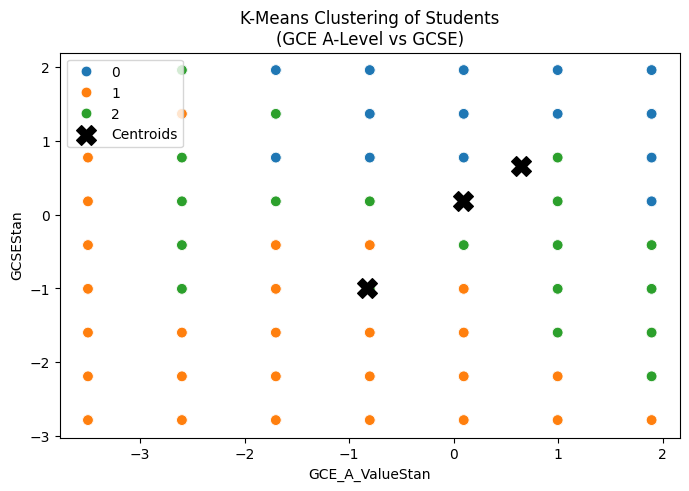

In [12]:
# Plot clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="GCE_A_ValueStan",
    y="GCSEStan",
    hue="Cluster",
    palette="tab10",
    s=60
)

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=200,
    c="black",
    marker="X",
    label="Centroids"
)

plt.title("K-Means Clustering of Students\n(GCE A-Level vs GCSE)")
plt.xlabel("GCE_A_ValueStan")
plt.ylabel("GCSEStan")
plt.legend()
plt.show()

In [13]:
# Find the optimal K Value
import warnings
warnings.filterwarnings('ignore')

StartK = 2
EndK = 15

# Impute missing values for clustering features
imputer = SimpleImputer(strategy="mean")
df[["GCE_A_ValueStan", "GCSEStan"]] = imputer.fit_transform(
    df[["GCE_A_ValueStan", "GCSEStan"]]
)

TotVar = []
Silhouette = []

for K in range(StartK, EndK):
    kmeans = KMeans(
        n_clusters=K,
        init="k-means++",
        n_init="auto",
        random_state=0
    )
    
    kmeans.fit(df[["GCE_A_ValueStan", "GCSEStan"]])
    labels = kmeans.labels_
    
    Silhouette.append(silhouette_score(df[["GCE_A_ValueStan", "GCSEStan"]], labels))
    TotVar.append(kmeans.inertia_)

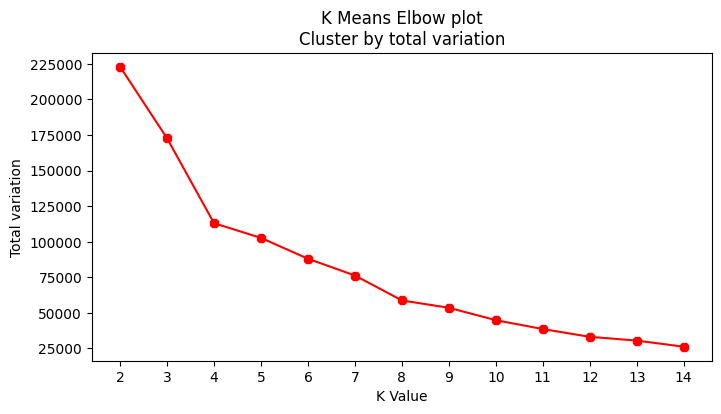

In [14]:
# Elbow plot
plt.figure(figsize=(8,4))
plt.plot(range(StartK, EndK), TotVar, color="red", marker="8")
plt.xlabel("K Value")
plt.xticks(np.arange(StartK, EndK,1))
plt.ylabel("Total variation")
plt.title("K Means Elbow plot\nCluster by total variation")
plt.show()

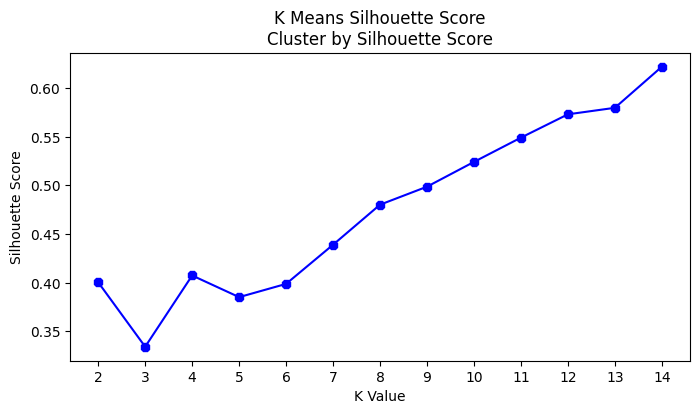

In [15]:
# Silhouette plot
plt.figure(figsize=(8,4))
plt.plot(range(StartK, EndK), Silhouette, color="blue", marker="8")
plt.xlabel("K Value")
plt.xticks(np.arange(StartK, EndK,1))
plt.ylabel("Silhouette Score")
plt.title("K Means Silhouette Score\nCluster by Silhouette Score")
plt.show()

In [16]:
# Table of results
LoopResults = pd.DataFrame(np.arange(StartK, EndK,1), columns=["K Value"])
LoopResults["Total Variation"] = TotVar
LoopResults["Silhouette Score"] = Silhouette
print(LoopResults)

    K Value  Total Variation  Silhouette Score
0         2    223043.458329          0.400501
1         3    172673.967738          0.334259
2         4    112946.676956          0.407498
3         5    102603.038307          0.385237
4         6     87941.838272          0.398856
5         7     76150.377421          0.439108
6         8     58612.655314          0.480282
7         9     53443.691818          0.498783
8        10     44729.456340          0.524261
9        11     38483.804162          0.549199
10       12     33003.619198          0.573174
11       13     30363.860879          0.579869
12       14     26052.736161          0.622107


In [17]:
# Final K-Means using K=7
kmeans = KMeans(n_clusters=7, init="k-means++", n_init="auto", random_state=0)
df["Cluster"] = kmeans.fit_predict(df[["GCE_A_ValueStan", "GCSEStan"]])
df.head()

,reference_id,SATS,GCSE,GCE_AS,GCE_A,GCSE_noisy,SATS_noisy,GCE_A_Value,A_Grade,GCE_AS_Value,GCE_A_ValueStan,GCE_AS_ValueStan,GCSEStan,SATStan,Cluster
0,835724108,107,5,B,B,5.993428,109.342761,40,0,20,0.097111,0.123804,-0.411730,0.264800,1
1,489964504,97,4,D,B,3.723471,96.858658,40,0,10,0.097111,-1.960878,-1.004573,-1.053444,2
2,153659217,111,6,A,A*,7.295377,109.005697,60,1,25,1.894798,1.166145,0.181114,0.792098,4
3,301853339,113,8,A,A,11.046060,110.917043,50,1,25,0.995954,1.166145,1.366800,1.055747,0
4,968991804,90,3,D,D,2.531693,89.486024,20,1,10,-1.700576,-1.960878,-1.597416,-1.976215,2


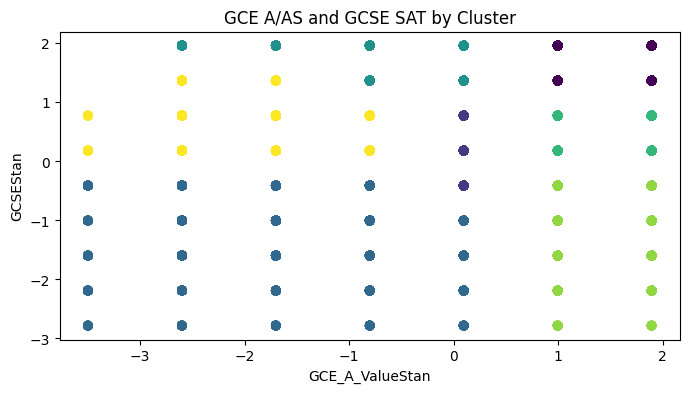

In [18]:
# Visualise the 8 Clusters
plt.figure(figsize=(8,4))
plt.scatter(df["GCE_A_ValueStan"], df["GCSEStan"], c=df["Cluster"])
plt.title("GCE A/AS and GCSE SAT by Cluster")
plt.xlabel("GCE_A_ValueStan")
plt.ylabel("GCSEStan")
plt.show()

In [19]:
#NEW SECTION: LOGISTIC REGRESSION TO PREDICT A GRADES

# Create binary target: 1 = A or A*, 0 = everything else
df["A_Grade"] = df["GCE_A"].isin(["A", "A*"]).astype(int)

In [20]:
# Select predictors for logistic regression (NO CLUSTERS)
# Use standardized features only
features = [
    "GCE_A_Value",
    "GCE_AS_Value",
    "GCSE_noisy",   
    "SATS_noisy"    
]

In [21]:
# Check missing values
print(df[features].isna().sum())

# Impute BEFORE creating X and y
imputer = SimpleImputer(strategy="mean")
df[features] = imputer.fit_transform(df[features])

# Now create X and y
X = df[features]
y = df["A_Grade"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


GCE_A_Value     0
GCE_AS_Value    0
GCSE_noisy      0
SATS_noisy      0
dtype: int64


In [22]:
# Scale ALL predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Fit Logistic Regression Model with L1 regularisation
log_reg = LogisticRegression(
    class_weight='balanced',
    max_iter=10000,
    solver='saga',      # supports L1 and elasticnet
    penalty='l1',       # still works but deprecated
    l1_ratio=1          # required for future versions (L1 = 1.0)
)

log_reg.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l1'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",1
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multicl

In [24]:
from sklearn.model_selection import cross_val_score

cv_acc = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring="accuracy")
cv_auc = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring="roc_auc")

print("Cross‑validated Accuracy:", cv_acc.mean())
print("Cross‑validated ROC‑AUC:", cv_auc.mean())

Cross‑validated Accuracy: 1.0
Cross‑validated ROC‑AUC: 1.0


In [25]:
# Evaluate Model
y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34759
           1       1.00      1.00      1.00     15241

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

[[34759     0]
 [    0 15241]]


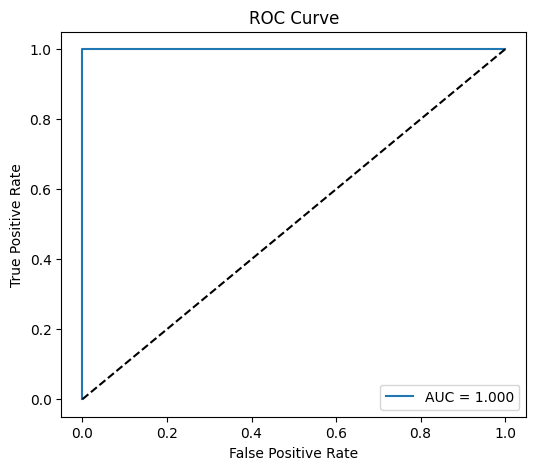

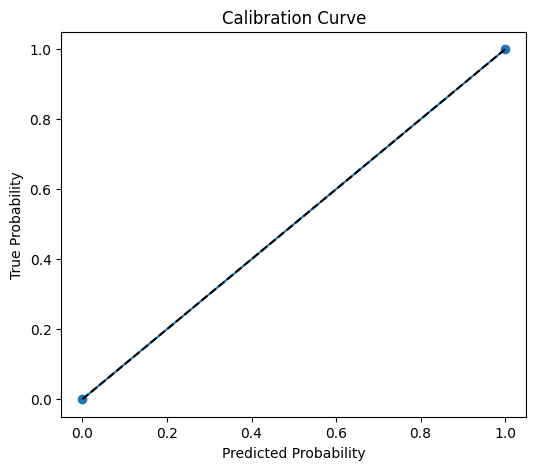

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve

# ROC curve
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.show()


In [27]:
#Model accuracy and probability threshold tuning

print("Accuracy:", accuracy_score(y_test, y_pred))

# Optional: custom threshold
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred_custom = (y_prob >= 0.6).astype(int)

print("\nCustom threshold (0.6) report:")
print(classification_report(y_test, y_pred_custom))

Accuracy: 1.0

Custom threshold (0.6) report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34759
           1       1.00      1.00      1.00     15241

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000



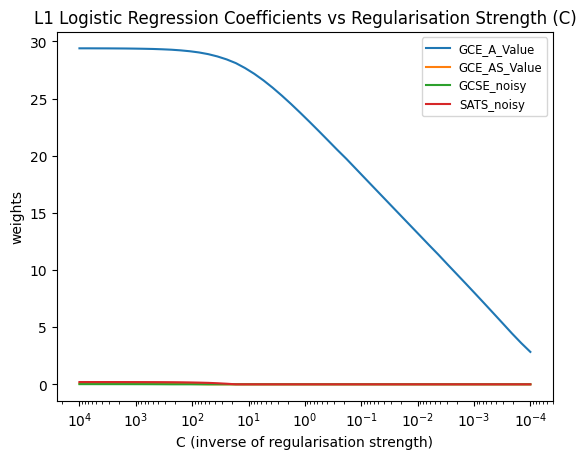

In [28]:
# Regularisation path for L1 Logistic Regression
Cs = np.logspace(-4, 4, 50)
coefs = []

for C in Cs:
    lr = LogisticRegression(
        class_weight='balanced',
        max_iter=10000,
        solver='saga',
        penalty='l1',
        l1_ratio=1,
        C=C
    )
    lr.fit(X_train_scaled, y_train)
    coefs.append(lr.coef_[0])

coefs = np.array(coefs)

# Plot coefficient paths
ax = plt.gca()
ax.plot(Cs, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("C (inverse of regularisation strength)")
plt.ylabel("weights")
plt.title("L1 Logistic Regression Coefficients vs Regularisation Strength (C)")
plt.axis("tight")
plt.legend(
    [f"{feat}" for feat in features],
    loc="best",
    fontsize="small"
)
plt.show()


In [29]:
#Feature importance (logistic regression coefficients)
coeffs = pd.DataFrame({
    "Feature": features,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print(coeffs)

        Feature  Coefficient
0   GCE_A_Value    23.362749
1  GCE_AS_Value     0.000000
2    GCSE_noisy     0.000000
3    SATS_noisy     0.000000


In [30]:
# Feature importance stability
coef_std = coefs.std(axis=0)
coef_mean = coefs.mean(axis=0)

stability_df = pd.DataFrame({
    "Feature": features,
    "Mean Coef": coef_mean,
    "Std Coef": coef_std,
    "Stability Ratio": np.abs(coef_mean) / (coef_std + 1e-6)
})

print("\nFeature Importance Stability:")
print(stability_df.sort_values("Stability Ratio", ascending=False))


Feature Importance Stability:
        Feature  Mean Coef  Std Coef  Stability Ratio
0   GCE_A_Value  20.592956  8.828357         2.332592
3    SATS_noisy   0.058380  0.084839         0.688120
1  GCE_AS_Value   0.015722  0.026377         0.596031
2    GCSE_noisy   0.002474  0.005174         0.478056


In [31]:
# %%
# Add predicted probability of achieving an A grade
df["Prob_A"] = log_reg.predict_proba(scaler.transform(df[features]))[:, 1]
df["Prob_A"] = df["Prob_A"].round(6)

df[["GCE_A", "Prob_A"]].head(20)


,GCE_A,Prob_A
0,B,0.000037
1,B,0.000037
2,A*,1.000000
3,A,0.999979
4,D,0.000000
5,B,0.000037
6,A,0.999979
7,C,0.000000
8,C,0.000000
9,D,0.000000
